<a href="https://colab.research.google.com/github/cbev/BROSS_ann_notebook/blob/master/Produce_ANN_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook for generating SSC Time Series from ANN models
Written by Claire Beveridge of University of Washington SASWE Research Group
Originally written on April 21, 2020
Last update April 21, 2020

**To execute the code a cell:** Select it by clicking on it. Then, either press the play button to the upper left of the code cell, or use the keyboard shortcut "Shift+Enter"

1. Execute the first two cells below. In the second cell, a box will appear below the cell for you to upload a file.

2. Upload the "ee-chart" file of the surface reflectance time series that was directly downloade from the BROSS GEE application. The file must have the name "ee-chart" for the code to run properly. It will say "Upload complete" when the file is laoded properly.

3. Execute the remaining cells. Time series will be displayed for the 


In [50]:
# Clone git 
!git clone 'https://github.com/cbev/BROSS_ann_notebook'

# Import relevant packages
%tensorflow_version 2.x
import os
os.chdir('/content/BROSS_ann_notebook')
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras import Sequential
from tensorflow.python.keras import layers
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pickle
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 1)
import io
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

# Script to upload files
from google.colab import files
if os.path.exists('ee-chart.csv'): os.remove('ee-chart.csv')
df = files.upload()
print('Upload Complete')

Cloning into 'BROSS_ann_notebook'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 19 (delta 5), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


Saving ee-chart.csv to ee-chart.csv
Upload Complete


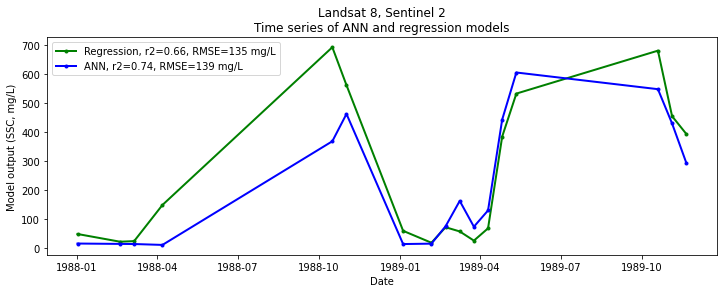

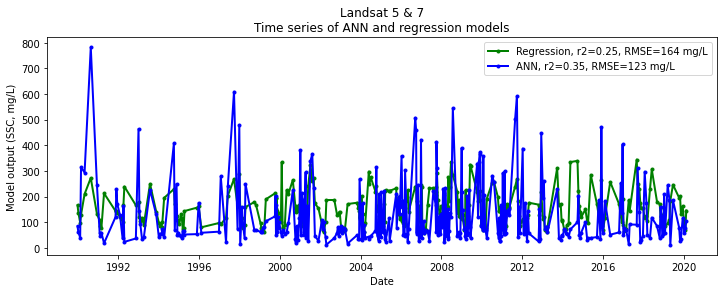

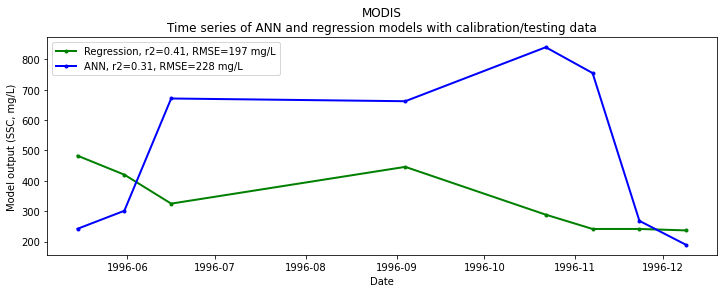

In [51]:
# Import the satellite reflectance data
df = pd.read_csv('ee-chart.csv', index_col=0) # assuming that saved in workspace as 'ee-chart'.
df.SatID=df.SatID.astype(int)
df.index=pd.to_datetime(df.index)    
df=df.groupby(df.index).mean()
df['TotalVIS']=df.Red+df.Blue+df.Green
df['Red_NIR']=df.Red/df.NIR;
df['Red_Green']=df.Red/df.Green;
df['Red_Blue']=df.Red/df.Blue;
df['Month']=df.index.month
df['RG_2']=(df['Red'].astype(np.float64)+df['Green'].astype(np.float64))/2 # (r+g)/2 
df['R_G_N']=(df['Red'].astype(np.float64)/df['Green'].astype(np.float64))+df['NIR'].astype(np.float64)
df=df.sort_index()
df=df[['SatID', 'Blue', 'Green', 'NIR', 'Red', 'TotalVIS', 'Red_Blue', 'Red_Green', 'Red_NIR','RG_2','R_G_N', 'Month']]

# Import the ANN input scaling values
scale_matrix = pickle.load(open('/content/BROSS_ann_notebook/scale_matrix.pkl','rb'))

# Prepare dataframes of satellite input data
### Landsat 8 and Sentinel-2
L8S2_df=df[df['SatID'].isin([2, 8])] 
L8S2_dates=L8S2_df.index
L8S2_df.reset_index(inplace=True, drop=True)
L8S2_df_scaled=(L8S2_df.values-scale_matrix['L8S2_mean'])/scale_matrix['L8S2_std'] # scale the data

### Landsat 5 and Landsat 7
L5L7_df=df[df['SatID'].isin([5, 7])] 
L5L7_dates=L5L7_df.index
L5L7_df.reset_index(inplace=True, drop=True)
L5L7_df=L5L7_df.drop(labels=['SatID'],axis=1)
L5L7_df_scaled=(L5L7_df.values-scale_matrix['L5L7_mean'])/scale_matrix['L5L7_std']

### MODIS
M_df=df[df['SatID'].isin([3])]    
M_dates=M_df.index
M_df.reset_index(inplace=True, drop=True)
M_df=M_df.drop(labels=['SatID','TotalVIS'],axis=1)
M_df_scaled=(M_df.values-scale_matrix['M_mean'])/scale_matrix['M_std']

# Compare ANN and regression- Landsat 8, Sentinel-2
if L8S2_df_scaled.size==0:
  print('No Landsat 8 or Sentinel 2 data in the input data\n')
  ann_output_L8S2=pd.DataFrame(); reg_output_L8S2=pd.DataFrame()
else: 
  # Run the ANN model using the inputs developed above
  ann_model_L8S2 = tf.keras.models.load_model('ann_L8S2.h5')
  ann_output_L8S2=pd.DataFrame(index=L8S2_dates.values, data=ann_model_L8S2.predict(L8S2_df_scaled), columns=['ann_ssc_mgL'])

  # Run the regression model
  def reg_model_L8S2 (red_over_green):
    ssc=0.161*np.exp(8.871*(red_over_green)-1.15)
    return ssc
  reg_output_L8S2=pd.DataFrame(index=L8S2_dates.values, data=reg_model_L8S2 (L8S2_df.Red_Green.values), columns=['regression_ssc_mgL'])

  fig1, ax1 =plt.subplots(1,1,figsize=(12,4))
  ax1.plot(reg_output_L8S2.index,reg_output_L8S2.regression_ssc_mgL, 'g.-', linewidth=2, label='Regression, r2=0.66, RMSE=135 mg/L')
  ax1.plot(ann_output_L8S2.index,ann_output_L8S2.ann_ssc_mgL,'b.-', linewidth=2, label='ANN, r2=0.74, RMSE=139 mg/L')
  ax1.legend(loc='best')
  ax1.set_title('Landsat 8, Sentinel 2\nTime series of ANN and regression models')
  ax1.set_ylabel('Model output (SSC, mg/L)')
  ax1.set_xlabel('Date');

  pd.concat([reg_output_L8S2,ann_output_L8S2], axis=1).to_csv('Landsat8Sentinel2_ssc_output.csv')
  files.download('Landsat8Sentinel2_ssc_output.csv')


  # Compare ANN and regression- Landsat 5 and 7
if L5L7_df_scaled.size==0:
  print('No Landsat 5 or Landsat 7 data in the input data\n')
  ann_output_L5L7=pd.DataFrame(); reg_output_L5L7=pd.DataFrame()
else: 
  # Run the ANN model using the inputs developed above
  ann_model_L5L7 = tf.keras.models.load_model('ann_L5L7.h5')
  ann_output_L5L7=pd.DataFrame(index=L5L7_dates.values, data=ann_model_L5L7.predict(L5L7_df_scaled), columns=['ann_ssc_mgL'])

  # Run the regression model
  def reg_model_L5L7 (red):
    ssc=3.56*np.exp(14.59*(red)+2.15)
    return ssc
  reg_output_L5L7=pd.DataFrame(index=L5L7_dates.values, data=reg_model_L5L7 (L5L7_df.Red.values), columns=['regression_ssc_mgL'])

  # Plot time series of ANN and regression model predictions
  fig1, ax1 =plt.subplots(1,1,figsize=(12,4))
  ax1.plot(reg_output_L5L7.index, reg_output_L5L7.regression_ssc_mgL, 'g.-', linewidth=2, label='Regression, r2=0.25, RMSE=164 mg/L')
  ax1.plot(ann_output_L5L7.index, ann_output_L5L7.ann_ssc_mgL,'b.-', linewidth=2, label='ANN, r2=0.35, RMSE=123 mg/L')
  ax1.legend(loc='best')
  ax1.set_title('Landsat 5 & 7\nTime series of ANN and regression models')
  ax1.set_ylabel('Model output (SSC, mg/L)')
  ax1.set_xlabel('Date');

  pd.concat([reg_output_L5L7,ann_output_L5L7], axis=1).to_csv('Landsat5Landsat7_ssc_output.csv')
  files.download('Landsat5Landsat7_ssc_output.csv')

# Compare ANN and regression- MODIS
if M_df_scaled.size==0:
  print('No MODIS data in the input data\n')
  ann_output_M=pd.DataFrame(); reg_output_M=pd.DataFrame()
else: 
  # Run the ANN model using the inputs developed above
  ann_model_M = tf.keras.models.load_model('ann_M.h5')
  ann_output_M=pd.DataFrame(index=M_dates.values, data=ann_model_M.predict(M_df_scaled), columns=['ann_ssc_mgL'])

  # Run the regression model
  def reg_model_M (red):
    ssc=2.74*np.exp(19.8*red+2.36)
    return ssc
  reg_output_M=pd.DataFrame(index=M_dates.values, data=reg_model_M (M_df.Red.values), columns=['regression_ssc_mgL'])

  # Plot time series of ANN and regression model predictions
  fig1, ax1 =plt.subplots(1,1,figsize=(12,4))
  ax1.plot(reg_output_M.index, reg_output_M.regression_ssc_mgL, 'g.-', linewidth=2, label='Regression, r2=0.41, RMSE=197 mg/L')
  ax1.plot(ann_output_M.index, ann_output_M.ann_ssc_mgL,'b.-', linewidth=2, label='ANN, r2=0.31, RMSE=228 mg/L')
  ax1.legend(loc='best')
  ax1.set_title('MODIS\nTime series of ANN and regression models with calibration/testing data')
  ax1.set_ylabel('Model output (SSC, mg/L)')
  ax1.set_xlabel('Date');

  pd.concat([reg_output_M,ann_output_M], axis=1).to_csv('MODIS_ssc_output.csv')
  files.download('MODIS_ssc_output.csv')